<a href="https://colab.research.google.com/github/EduardoLawson1/Pytorch-Practice/blob/main/Pytorch%20Paper%20Replicating/Pytorch_Paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Milestone Project 2: Pytorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research
paper into usable code.

## 0. Get setup

Let's import code previously written and libraries.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

The goal here, is replicate the ViT architecture for our FoodVision Mini Problem

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [7]:
import os
from going_modular.going_modular import data_setup
from torchvision import transforms

#Create image size
IMG_SIZE = 224 # Comes from table 3 of the ViT paper

manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor(),
])

print(f"Manually crated transforms {manual_transforms}")

Manually crated transforms Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Creating dataloaders
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms,
                                                                    batch_size=BATCH_SIZE,
                                                                    num_workers=os.cpu_count())

len(train_dataloader), len(test_dataloader), class_names
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c3cd65ae890>,
 ['pizza', 'steak', 'sushi'])

### 2.3 VIsualize a single image

As always, let's adhere to the motto, visualize, visualize!

In [9]:
# Get a batch of images

image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

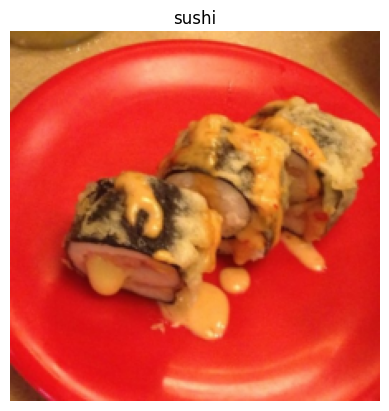

In [10]:
# Plot the image with matplotlib

import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview
Before we write any more code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our model inputs are: images of pizza, steak and sushi.

And our ideal model outputs are: predicted labels of pizza, steak or sushi.

No different to what we've been doing throughout the previous sections.

The question is: how do we go from our inputs to the desired outputs?

## 4. Equation 1: Split daa into patches and creating the class, position and patch embedding

 Layers = input -> function -> output

 What's the input shape?

 What's the output shape?

 * Input shape: (224, 224, 3) -> Single image (height, width, color channels)

 * Output shape: ${N \times\left(P^{2} \cdot C\right)}$
 * H = Heigth
 * W = Width
 * C = Color channels
 * P = Patch size
 * N = number of patches = (height * width) / p^2
 * D = constant latent vector size = embedding dimension

In [11]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f" Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

 Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

Let's visualize, visualize, visualize!

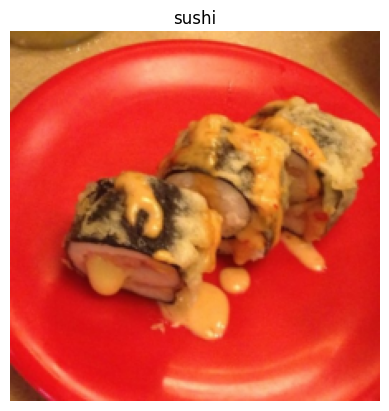

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [14]:
image.shape

torch.Size([3, 224, 224])

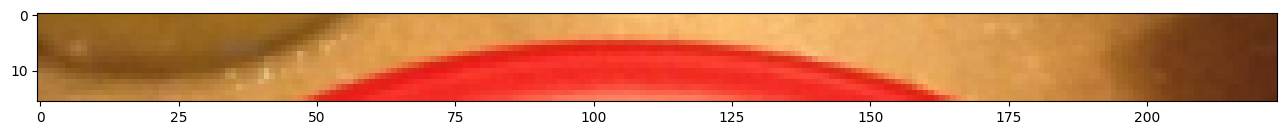

In [15]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert to color channels last
# Index to plot the top row of pixeçs
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


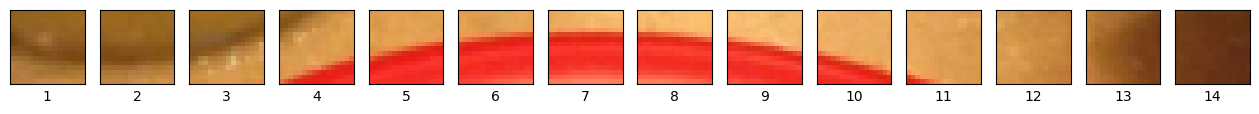

In [16]:
# Setup code to plot top row as patches
img_size = 224
patch_size =16
num_patches = img_size/patch_size
assert img_size % patch_size == 0

print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per colum: 14.0  
Total patches: 196.0  
Parch size: 16 pixels x 16 pixels


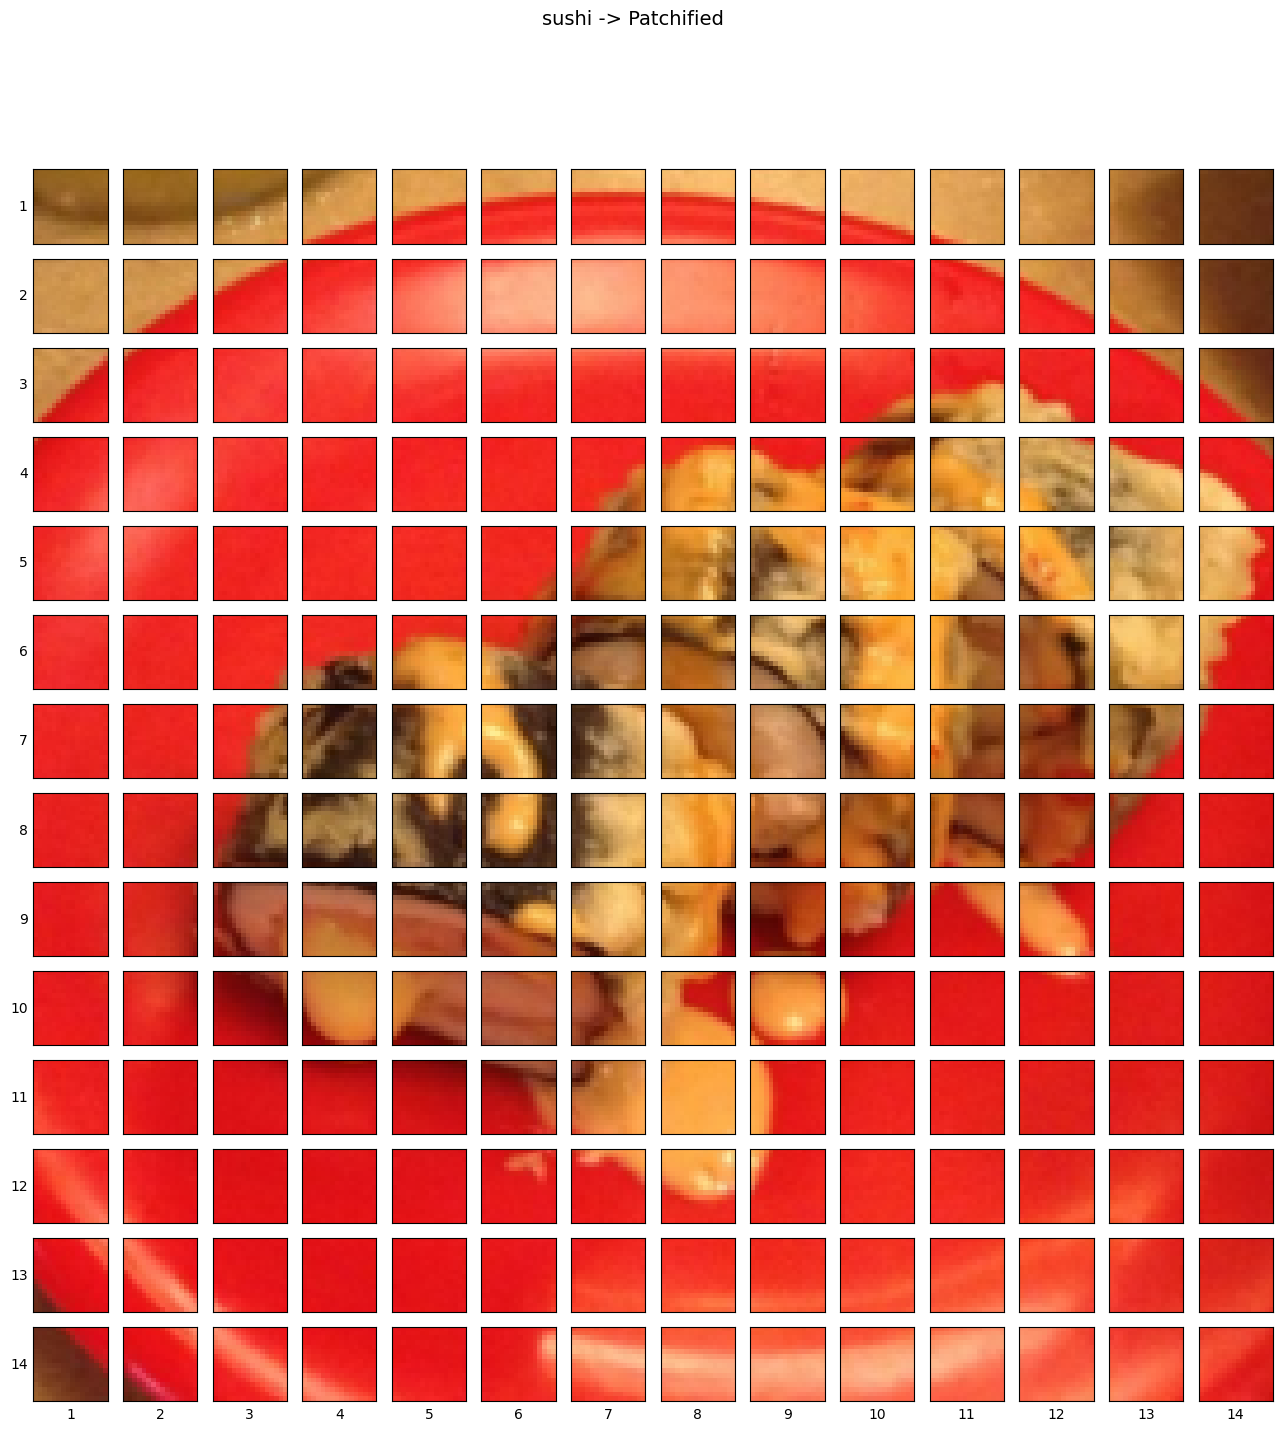

In [17]:
# Setup code to plot whole image as patches
img_size = 224
patch_size =16
num_patches = img_size/patch_size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per colum: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nParch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                       ncols=img_size // patch_size,
                       figsize=(patch_size, patch_size),
                       sharex=True,
                       sharey=True)

# Loop through heigth and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): #height
 for j, patch_width in enumerate(range(0, img_size, patch_size)):
  # Plot the permuted image on the diferent axes
  axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                  patch_width:patch_width+patch_size, # iterate through width
                                  :])
  # Set up label information for each subplot (patch)
  axs[i, j].set_ylabel(i+1,
                       rotation="horizontal",
                       horizontalalignment="right",
                       verticalalignment="center")
  axs[i,j].set_xlabel(j+1)
  axs[i, j].set_xticks([])
  axs[i, j].set_yticks([])
  axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

In [18]:
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2D lauer with hyperparameters from ViT
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

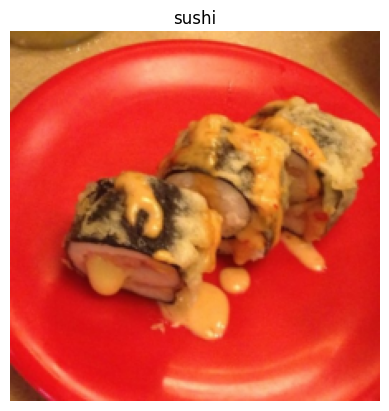

In [19]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [20]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [21]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes [73, 514, 140, 652, 558]


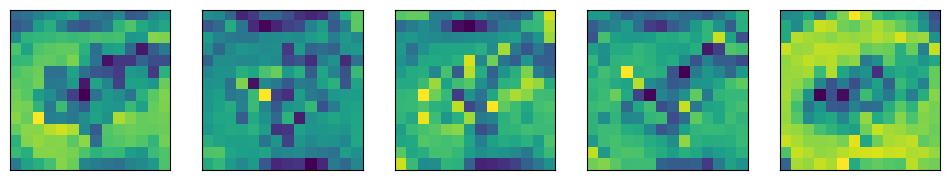

In [22]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes {random_indexes}")
# Create plots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # Index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [23]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.4340, -0.4569, -0.4774, -0.6040, -0.8390, -0.7541, -0.7503,
           -0.7546, -0.7951, -0.7352, -0.7017, -0.6168, -0.4631, -0.3117],
          [-0.6255, -0.6417, -0.8139, -0.8291, -0.8217, -0.8058, -0.8141,
           -0.8222, -0.8233, -0.8417, -0.7778, -0.6893, -0.5311, -0.3325],
          [-0.7912, -0.8113, -0.8508, -0.8555, -0.8690, -0.8773, -0.8591,
           -0.8450, -0.8396, -0.8035, -0.7270, -0.7448, -0.7874, -0.5773],
          [-0.8137, -0.8356, -0.8526, -0.8525, -0.8504, -0.8436, -0.7864,
           -0.7055, -0.6951, -0.6485, -0.7128, -0.6271, -0.6480, -0.7218],
          [-0.8308, -0.8620, -0.8417, -0.8399, -0.8384, -0.8427, -0.5690,
           -0.6102, -0.5096, -0.7497, -0.6376, -0.6438, -0.6716, -0.7969],
          [-0.8402, -0.8364, -0.8403, -0.6398, -0.7165, -0.5637, -0.3501,
           -0.4405, -0.5654, -0.6642, -0.5529, -0.4491, -0.7035, -0.7975],
          [-0.8207, -0.8040, -0.7144, -0.2701, -0.4210, -0.6059, -0.3861,
           -0.6714, -0.5772, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

In [24]:
print(f"{image_out_of_conv.shape} -> batch, embedding dim, feature map height, feature map width")

torch.Size([1, 768, 14, 14]) -> batch, embedding dim, feature map height, feature map width


In [25]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape? torch.Size([3, 224, 224])
 Image feature map (patches) shape torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


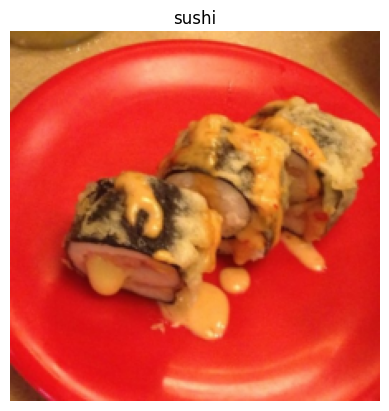

In [26]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape? {image.shape}")

# Turn image into feature maps
image_out_of_conv.unsqueeze(0) # add batch dimension
print(f" Image feature map (patches) shape {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [27]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> batch, number of patches, embedding dimension")

torch.Size([1, 196, 768]) -> batch, number of patches, embedding dimension


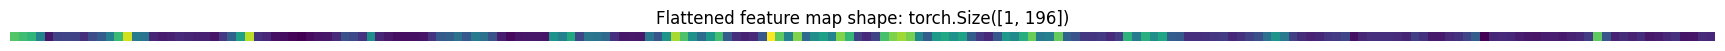

In [28]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the Vit patch embedding layer into a Pytorch module
We want this module to do a few thing
1. Create a class called Patch nn.Embedding
2. Initialize with appropriate hyperparameters, such as channels, embedding
dimension, patch size.
3. Create a layer to turn a image into embedding patches using nn.conv2d
4. Create a layer to flatten the feature maps of the output of layer in 3
5. Define a foward() computation
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [29]:
# Step 1: Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # From table 1 ViT
    super().__init__()

    self.patch_size = patch_size
    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    # 4. Create a layer to flatten feature map outputs of COnv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
  # 5. Define a foward method to define the foward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size"

    # Perform the foward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make the returned sequence embedding dimensions are in the right order
    return x_flattened.permute(0, 2, 1)


In [30]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f" Output patch embedding sequence shape: {patch_embedded_image.shape}")

input image size: torch.Size([1, 3, 224, 224])
 Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [31]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

### 4.6 Creating the class token embedding
Wanto to: prepend a learnable class token to the start of the patch embedding

In [32]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [33]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [34]:
# Create class token embedding as a learnable parameter tha shares the same size as the embedding dimensiond (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [35]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [36]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number of patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepend shape: {patch_embedded_image_with_class_embedding.shape}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4863,  0.0423, -0.1511,  ...,  0.2779, -0.2365,  0.1976],
         [-0.5074,  0.0786, -0.1432,  ...,  0.3041, -0.2911,  0.1613],
         ...,
         [-0.6637, -0.0663, -0.0624,  ...,  0.3660, -0.3921,  0.2844],
         [-0.6193, -0.0239, -0.0852,  ...,  0.3110, -0.2955,  0.2785],
         [-0.5729, -0.0957,  0.0432,  ...,  0.1739, -0.3164,  0.2667]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepend shape: torch.Size([1, 197, 768])


### 4.7 Creating the position embedding

In [37]:
# View the sequence of patch embedding with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4863,  0.0423, -0.1511,  ...,  0.2779, -0.2365,  0.1976],
          [-0.5074,  0.0786, -0.1432,  ...,  0.3041, -0.2911,  0.1613],
          ...,
          [-0.6637, -0.0663, -0.0624,  ...,  0.3660, -0.3921,  0.2844],
          [-0.6193, -0.0239, -0.0852,  ...,  0.3110, -0.2955,  0.2785],
          [-0.5729, -0.0957,  0.0432,  ...,  0.1739, -0.3164,  0.2667]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [38]:
# Calculate N (Number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Getting the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [39]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and postion embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5137, 1.0423, 0.8489,  ..., 1.2779, 0.7635, 1.1976],
         [0.4926, 1.0786, 0.8568,  ..., 1.3041, 0.7089, 1.1613],
         ...,
         [0.3363, 0.9337, 0.9376,  ..., 1.3660, 0.6079, 1.2844],
         [0.3807, 0.9761, 0.9148,  ..., 1.3110, 0.7045, 1.2785],
         [0.4271, 0.9043, 1.0432,  ..., 1.1739, 0.6836, 1.2667]]],
       grad_fn=<AddBackward0>)
Patch and postion embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding


In [40]:
# Set the seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2.Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create a patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through patch embedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure its learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create the position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [41]:
image.shape

torch.Size([3, 224, 224])

## Equation 2: Multihead Self-Attention (MSA block)

In [42]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block (MSA)"""
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D (embedding dimension)
                 num_heads:int=12, # Heads from table 1 for VIT-Base
                 attn_dropout:int=0):
      # Create LayerNorm
      super().__init__()
      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

      # Create the MSA
      self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  dropout=attn_dropout,
                                                  batch_first=True) # batch, number of patches, embedding_dimension
    def forward(self, x):
      x = self.layer_norm(x)
      attn_output, _ = self.multihead_attn(query=x,
                                           key=x,
                                           value=x,
                                           need_weights=False)
      return attn_output



In [43]:
# Create a instance MSA block
multi_head_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multi_head_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## Equation 3: Multi Layer Perceptron (MLP)
* **MP** = The MLP contains two layers with a GELU non-linearity (section 3.1)
  * MLP = a quite broad term for a block with a series of layer(s), layers can be
multiple or even oly one hidden layer.
  * Layer can mean: fully-connected, dense, linear, feed-forward.
  * MLP number of hidden units = MLP size in Table 1 = 3072
* **Dropout** = Dropout, when used, is applied after every dense layer except for the qkv-projections and directly after adding position-to patch embedding. Hybrid models are trained with the exct setup as their ViT counterparts.
  * Value of Dropout in Table 3 of the paper - 0.1


In pseudocode:
```python
#MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [44]:
class MLPBlock(nn.Module):
  """Creates a MultiLayer Perceptron block"""
  def __init__(self,
              embedding_dim:int=768,
              mlp_size:int=3072,
              dropout:int=0.1):
    super().__init__()

    # Create the Layer Norm (LM)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Crate the MLP layer
    self.mlp_layer = nn.Sequential(
        nn.Linear(in_features=embedding_dimension,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp_layer(x)
    return x


In [45]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape: {patched_image_through_msa_block.shape}")
print(f"Output shape: {patched_image_through_mlp_block.shape}")


Input shape: torch.Size([1, 197, 768])
Output shape: torch.Size([1, 197, 768])


### 7.1
 Creating the Transformer Encoder

The Transformer Ecncoder is a combination of alternating blocks of MSA (equeation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation to back to some sort of sequence
* Residual connections =  add a layer(s) input to iss subsequence output, this enables the cretion of deeper networks (prevents wrights from getting too small)

In pseudocode:
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input]

In [46]:
# A terminar...
class TransformerEnconderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:int=0.1,
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [47]:
# Create an instance of Transformer Encoder Block
transformer_encoder_block = TransformerEnconderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEnconderBlock (TransformerEnconderBlock)     [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)              --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_layer)                           [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 7.2 Create a Transformer Encoder Layer with in-built Pytorch Layers

In [48]:
# Create the same as above with torch.nn.TransformerEncoderLayer
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,#embedding size
                                                             nhead=12, # number of heads
                                                             dim_feedforward=3072, # MLP size
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8. Putting it all togetther to create ViT


In [49]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # from the paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "layers" for vit base
               embedding_dim:int=768, # Hidden size D from Table 1
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embbedding_dropout:int=0.1, # DROPOUT FOR PATCH AND POSITION EMBEDDINGS
               num_classes:int=1000):  #Image net
    super().__init__()

    # Make an assrtion that the image size is compatible with the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, img size: {img_size}, patch_size: {patch_size}"

    # Calculate the number of patches (height * width/patch²)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create the position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # CReate embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embbedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEnconderBlock(embedding_dim=embedding_dim,
                                                                        num_heads=num_heads,
                                                                        mlp_size=mlp_size,
                                                                        mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # Create the patch embedding
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding
    x = torch.cat((class_token, x),dim =1)

    # Add position embedding to class token and patch embedding

    x = self.position_embedding + x

    # Apply dropout
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to transformer encoder
    x = self.transformer_encoder(x)

    # Put 0th index
    x = self.classifier(x[:,0])

    return x




In [50]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEnconderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp_layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
 

In [51]:
set_seeds()

# Create a random image tensor
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our VIT
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a summary


In [52]:
summary(model=ViT(num_classes=1000),
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
ViT (ViT)                                                    [1, 3, 224, 224]          [1, 1000]                 152,064                   True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]          [1, 196, 768]             --                        True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]          [1, 768, 196]             --                        --
├─Dropout (embedding_dropout)                                [1, 197, 768]             [1, 197, 768]             --                        --
├─Sequential (transformer_encoder)                           [1, 197, 768]             [1, 197, 768]             --                    

## 9. Setting up training code for our custom ViT

### 9.1 Creating an optimizer

### 9.2 Creating a loss function

### 9.3 Training our ViT model

In [56]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device,
                       model=vit
                      )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1750 | train_acc: 0.2305 | test_loss: 3.4148 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9413 | train_acc: 0.2617 | test_loss: 1.0694 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1667 | train_acc: 0.2383 | test_loss: 1.0047 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.2205 | train_acc: 0.2852 | test_loss: 1.1959 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1425 | train_acc: 0.2773 | test_loss: 1.3895 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1319 | train_acc: 0.4297 | test_loss: 1.3772 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1455 | train_acc: 0.4102 | test_loss: 1.1806 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.1271 | train_acc: 0.2969 | test_loss: 1.1832 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1615 | train_acc: 0.2695 | test_loss: 1.1934 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1147 | train_acc: 0.2812 | test_loss: 1.1903 | test_acc: 0.1979


### 9.4 What our training setup is missing

Lack of data and pre-training.

### 9.5 Plotting loss curves for our model

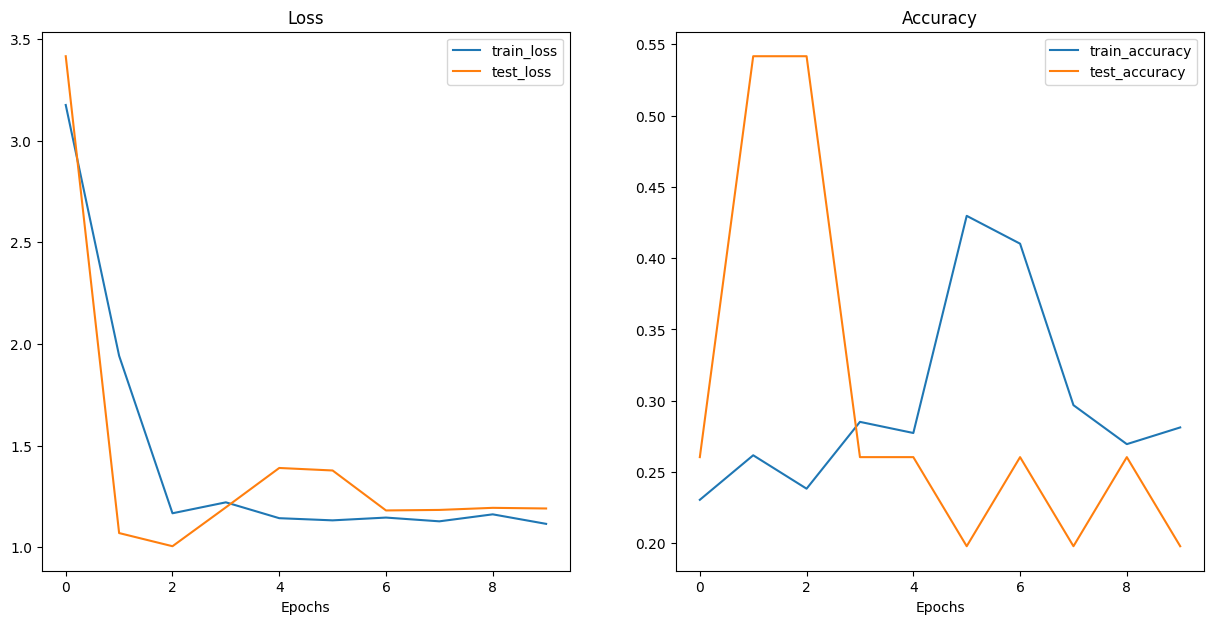

In [57]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)